导入所需要的库

In [1]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
#用于对图像数据进行增强和预处理。它通过对原始图像进行一系列的变换和操作，生成新的图像样本，从而扩充训练数据集的规模和多样性。
import numpy as np
import pandas as pd
import cv2

import matplotlib.pyplot as plt

调用GPU

In [2]:
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(device=gpu, enable=True)   

指定训练集和测试集所在目录的路径

In [3]:
train_dir = 'C:/Users/liuyang/Desktop/000/flower_data/train'
test_dir = 'C:/Users/liuyang/Desktop/000/flower_data/val'


使用 OpenCV 加载一张图像，并将其从 BGR（蓝绿红）颜色空间转换为 RGB（红绿蓝）颜色空间。

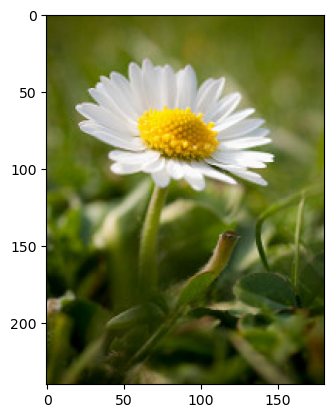

In [4]:
img_BGR = cv2.imread('C:/Users/liuyang/Desktop/000/flower_data/001.jpg',1)
img1 = cv2.cvtColor(img_BGR, cv2.COLOR_BGR2RGB)  # 将BGR颜色空间转换为RGB颜色空间
plt.imshow(img1)

对训练数据归一化并进行了水平翻转，扩充训练数据集的规模和多样性

In [5]:
train_images = ImageDataGenerator(rescale = 1/255,horizontal_flip=True)   
test_images = ImageDataGenerator(rescale = 1/255)

按路径载入图片，批处理大小，随机打乱，尺寸，用读热编码对标签进行处理

In [6]:
train_gen = train_images.flow_from_directory(directory=train_dir,
                                             batch_size=32,
                                             shuffle=True,
                                             target_size=(224, 224),
                                             class_mode='categorical')

Found 3306 images belonging to 5 classes.


In [7]:
val_gen = test_images.flow_from_directory(directory=test_dir,
                                          batch_size=32,
                                          shuffle=False,
                                          target_size=(224, 224),
                                          class_mode='categorical')

Found 364 images belonging to 5 classes.


类别查看

In [8]:
classes = train_gen.class_indices
classes

{'daisy': 0, 'dandelion': 1, 'roses': 2, 'sunflowers': 3, 'tulips': 4}

搭建ResNet网络

In [9]:
def BasicBlock(filter_num, strides, _inputs):

    x = tf.keras.layers.Conv2D(filters=filter_num, kernel_size=3, strides=strides, padding='same')(_inputs)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation('relu')(x)
    x = tf.keras.layers.Conv2D(filter_num, kernel_size=3, strides=1, padding='same')(x)
    x = tf.keras.layers.BatchNormalization()(x)
        
    if strides != 1:
        y = tf.keras.layers.Conv2D(filters=filter_num,kernel_size=1,strides=strides)(_inputs)
        y = tf.keras.layers.BatchNormalization()(y)
    else:
        y = _inputs
        
    output = tf.keras.layers.add([x, y])
    output = tf.keras.layers.Activation('relu')(output)
    
    return output


In [10]:
def ResNet18(): #2 2 2 2
    input_image = tf.keras.layers.Input(shape=(224, 224, 3))
    x = tf.keras.layers.Conv2D(64, kernel_size=7, strides=2,padding="same")(input_image)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation('relu')(x)
    x = tf.keras.layers.MaxPool2D(pool_size=3,strides=2,padding="same")(x)
    
    x = BasicBlock(64,strides=1,_inputs=x)
    x = BasicBlock(64,strides=1,_inputs=x)
    
    x = BasicBlock(128,strides=2,_inputs=x)
    x = BasicBlock(128,strides=1,_inputs=x)
    
    x = BasicBlock(256,strides=2,_inputs=x)
    x = BasicBlock(256,strides=1,_inputs=x)
    
    x = BasicBlock(512,strides=2,_inputs=x)
    x = BasicBlock(512,strides=1,_inputs=x)
    
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    x = tf.keras.layers.Dense(5, activation='softmax')(x)
    
    model = tf.keras.models.Model(inputs=input_image, outputs=x)
    return model

In [11]:
model = ResNet18()

In [12]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 112, 112, 64) 9472        input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 112, 112, 64) 256         conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 112, 112, 64) 0           batch_normalization[0][0]        
______________________________________________________________________________________________

设置模型训练模式

In [13]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005),
              loss='categorical_crossentropy',
              metrics=['acc'])


训练模型

In [14]:
history = model.fit(train_gen,
                    epochs=9,
                    validation_data=val_gen)

Train for 104 steps, validate for 12 steps
Epoch 1/9
104/104 [==============================] - 33s 316ms/step - loss: 1.3025 - acc: 0.5194 - val_loss: 2.8225 - val_acc: 0.2610
Epoch 2/9
104/104 [==============================] - 26s 247ms/step - loss: 0.9698 - acc: 0.6364 - val_loss: 3.5390 - val_acc: 0.2445
Epoch 3/9
104/104 [==============================] - 26s 249ms/step - loss: 0.8565 - acc: 0.6751 - val_loss: 2.7499 - val_acc: 0.3984
Epoch 4/9
104/104 [==============================] - 26s 249ms/step - loss: 0.7850 - acc: 0.7154 - val_loss: 1.2336 - val_acc: 0.5549
Epoch 5/9
104/104 [==============================] - 27s 258ms/step - loss: 0.7414 - acc: 0.7232 - val_loss: 0.9405 - val_acc: 0.6648
Epoch 6/9
104/104 [==============================] - 26s 247ms/step - loss: 0.6880 - acc: 0.7438 - val_loss: 1.3461 - val_acc: 0.6099
Epoch 7/9
104/104 [==============================] - 26s 247ms/step - loss: 0.6394 - acc: 0.7626 - val_loss: 1.5366 - val_acc: 0.5934
Epoch 8/9
104/104 [

定义训练过程可视化函数

In [15]:
def visu_train_history(history,train_metric,validation_metric):
    plt.plot(history.history[train_metric])
    plt.plot(history.history[validation_metric])
    plt.title('Train History')
    plt.ylabel(train_metric)
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper left')
    plt.show()

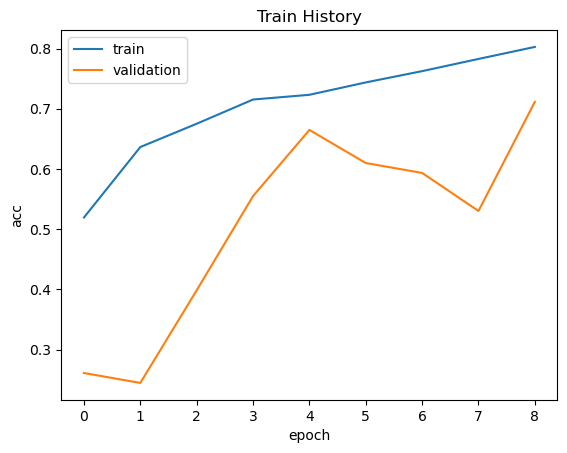

In [16]:
visu_train_history(history,'acc','val_acc')

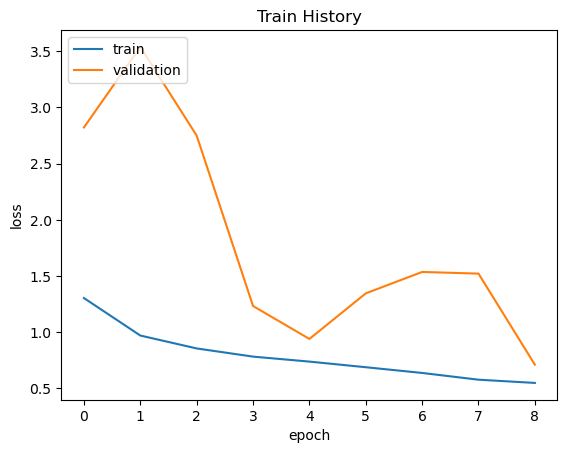

In [17]:
visu_train_history(history,'loss','val_loss')

评估模型

In [18]:
model.evaluate(val_gen)

12/12 [==============================] - 2s 129ms/step - loss: 0.7114 - acc: 0.7115


[0.7114352087179819, 0.71153843]

使用 OpenCV 加载要预测的图像

In [19]:
img_BGR = cv2.imread('C:/Users/liuyang/Desktop/000/flower_data/002.jpg',1)
img = cv2.cvtColor(img_BGR, cv2.COLOR_BGR2RGB)  # 将BGR颜色空间转换为RGB颜色空间


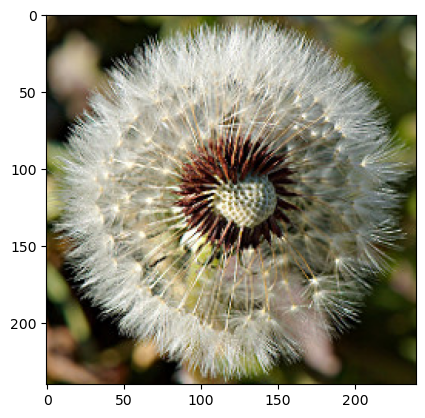

In [20]:
plt.imshow(img)

In [21]:
#图片预处理
img = cv2.resize(img,(224,224))
img = img.reshape(1,224,224,3)
img = img/255

应用模型预测

In [22]:
predict = model.predict(img)
predict

array([[0.12381406, 0.6264213 , 0.22540879, 0.0060792 , 0.01827659]],
      dtype=float32)

In [23]:
label = ['daisy','dandelion','roses','sunflowers','tulips']
label[np.argmax(predict)]

'dandelion'